In [7]:
import numpy as np
from scipy.optimize import minimize

# Задаем матрицу A и центр эллипса y
A = np.array([[1., 0.], [-1., 1.]])  # Задайте вашу матрицу здесь
y = np.array([3., 2.])  # Задайте координаты центра эллипса

# Задаем исходную точку x
x = np.array([4.,1.])  # Задайте исходную точку

# Функция цели: минимизация евклидова расстояния
def objective(x_star):
    return np.linalg.norm(x - x_star)**2

# Условие для эллипса
def constraint(x_star):
    return (x_star - y).T @ A @ (x_star - y) - 1

cons = ({'type': 'eq', 'fun': constraint})

# Начальное приближение (может быть выбрано произвольно, например, исходная точка x)
x0 = x

# Решение задачи оптимизации
result = minimize(objective, x0, method='SLSQP', constraints=cons)

# Выводим результат
print("Решение:", result.x)

Решение: [3.57735022 1.42264968]


[2. 1.]


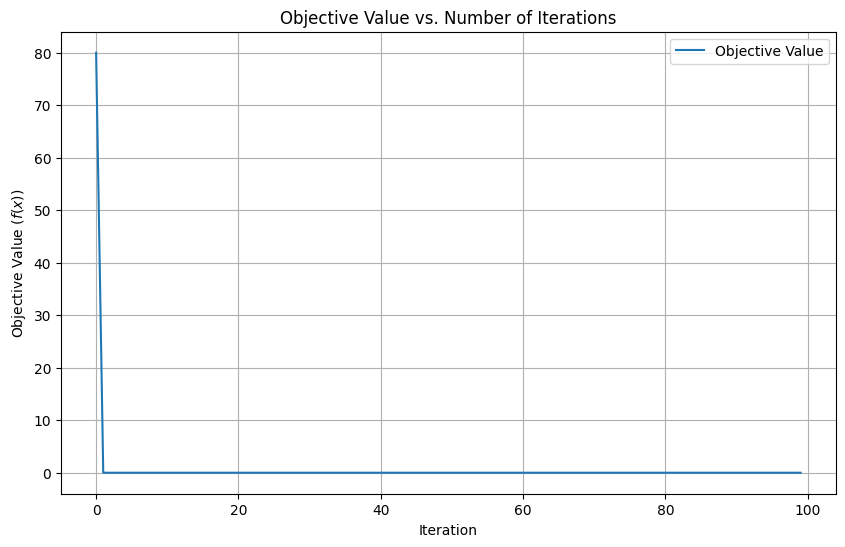

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def project_on_U(x, y, A):
    """Project x on the set U defined by (x-y)^T A (x-y) <= 1."""
    # Solving the quadratic problem might be complex in a real situation, but here we approximate
    # the projection by moving the point x directly towards y if it's outside U.
    if (x - y).T @ A @ (x - y) <= 1:
        return x
    else:
        return y + (x - y) / np.sqrt((x - y).T @ A @ (x - y))


def project_on_V(x, Sigma):
    """Project x on the set V defined by ||Sigma x||_inf <= 1."""
    # Normalize x to meet the infinity norm constraint directly.
    return np.sign(x) * np.minimum(np.abs(x), 1 / np.diag(Sigma))

def dist_to_U(x, y, A):
    """Compute the squared distance of x to the set U."""
    dist = (x - y).T @ A @ (x - y) - 1
    return dist if dist > 0 else 0

def dist_to_V(x, Sigma):
    """Compute the squared distance of x to the set V."""
    # Measure how far x is from satisfying the constraint, squared.
    return np.max(np.square(Sigma @ x) - 1)

def optimize(x, y, Sigma, A, iterations=100):
    f_values = []
    for _ in range(iterations):
        dist_U = dist_to_U(x, y, A)
        dist_V = dist_to_V(x, Sigma)
        f_values.append(max(dist_U, dist_V))
        
        if dist_U > dist_V:
            x = project_on_U(x, y, A)
        else:
            x = project_on_V(x, Sigma)
            
    return x, f_values

# Initial data and matrix setup
n = 2
y = np.array([3, 2])
Sigma = np.diag([0.5, 1])
A = np.array([[1, 0], [-1, 1]])
x_init = np.array([3, 9])

x_final, f_values = optimize(x_init, y, Sigma, A, 100)
print(x_final)

# Plotting the objective value vs. iterations
plt.figure(figsize=(10, 6))
plt.plot(f_values, label='Objective Value')
plt.xlabel('Iteration')
plt.ylabel('Objective Value ($f(x)$)')
plt.title('Objective Value vs. Number of Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
def proj_U(x, y=np.array([3, 2]), A=np.array([[1, 0], [-1, 1]]), lambda_init=0.01, tol=1e-5, max_iter=100000):
    I = np.identity(A.shape[0])
    lambda_ = lambda_init

    # Если точка внутри множества - её и возвращаем
    if (x-y).T @ A @ (x-y) <= 1:
        return x

    # Процедура бэктрекинга для подбора множителей Лагранжа
    for _ in range(max_iter):
        z_star = np.dot(x + lambda_ * np.dot(A + A.T, y), np.linalg.inv(I + lambda_ * (A + A.T)))  # выведенная формула
        constraint_value = np.dot(np.dot((z_star - y).T, A), (z_star - y))
        
        if abs(constraint_value - 1) <= tol:
            return z_star
        
        if constraint_value > 1:
            lambda_ *= 1.1  # Если мы слишком далеко, увеличиваем lambda_
        else:
            lambda_ *= 0.9  # Если мы слишком близко, уменьшаем lambda_
        
    return None, None  # Если не подобрали множители


# Пример использования функции
x_example = np.array([1., 0.])
z_star = proj_U(x_example)
print(z_star)

[1.999996 0.999996]


In [31]:
def proj_U_(x, y=np.array([3, 2]), A=np.array([[1, 0], [-1, 1]])):
    def objective(z):
        return 0.5 * np.sum((z - x)**2)
    
    def constraint(z):
        return 1 - (z-y).T @ A @ (z-y)
    
    cons = {'type': 'ineq', 'fun': constraint}
    result = minimize(objective, x0=x, constraints=cons)
    return result.x

z_star_new = proj_U_(x_example)
print(z_star_new)


[3.95236861 3.04164476]
